In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, math, random
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from pytorch3d.utils import ico_sphere
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from src.training import weights_init_normal
from pytorch3d.io import load_objs_as_meshes
from src.notebook_utils import imshow, imgrid
from notebooks.utils import imshow, imgrid

In [3]:
src_mesh = ico_sphere(1)
mesh_shape = src_mesh.verts_packed().shape

In [4]:
SPHERES_PER_SET = 6
NUM_SETS = 6
IMG_SIZE=128

In [5]:
X = torch.randn(NUM_SETS * SPHERES_PER_SET * mesh_shape[0], mesh_shape[1]).cuda()
print(X.shape)

torch.Size([1512, 3])


In [6]:
meshes = src_mesh.extend(SPHERES_PER_SET * NUM_SETS).cuda()

In [7]:
meshes.verts_packed().shape

torch.Size([1512, 3])

In [8]:
class Classifier(nn.Module):
    def __init__(self, img_size, spheres_per_set, num_sets, channels=1):
        super(Classifier, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_size*img_size*channels, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, spheres_per_set+num_sets),
            #nn.Sigmoid()
#             nn.Tanh(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [9]:
# device = torch.device("cuda")
# torch.cuda.set_device(device)
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)
class Generator():
    def __init__(self, meshes, img_size):
        self.meshes = meshes
        """ Setup rendering. """
        self.lights = PointLights(location=[[0.0, 0.0, -3.0]], device='cuda')

        sigma = 1e-4
        raster_settings_silhouette = RasterizationSettings(
            image_size=img_size, 
            blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
            faces_per_pixel=50, 
        )
        self.renderer_silhouette = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=raster_settings_silhouette
            ),
            shader=SoftSilhouetteShader()
        ).cuda()
    
    def __call__(self, X):
        new_meshes = self.meshes.offset_verts(X*2)

#         elev = torch.FloatTensor(8).uniform_(-5, 5)
#        
        n = SPHERES_PER_SET * NUM_SETS
        elev = torch.FloatTensor(n).uniform_(-5, 50)
        #azim = torch.FloatTensor(n).uniform_(0, 0)
        azim = torch.FloatTensor(n).uniform_(-60, 60)
        #azim = torch.FloatTensor(n).uniform_(-20, 20)


        R, T = look_at_view_transform(dist=3, elev=elev, azim=azim)
        cameras = OpenGLPerspectiveCameras(R=R, T=T, device='cuda')

        images_predicted = self.renderer_silhouette(
            new_meshes,
            cameras=cameras,
            lights=self.lights
        )
        predicted_silhouette = images_predicted[..., 3]
        return new_meshes, predicted_silhouette

In [10]:
def draw_tensor(tensor, nmax=100, cols=SPHERES_PER_SET):
    images = (np.clip(tensor.detach().cpu().numpy(), 0, 1) * 255).astype('uint8')
    imshow(imgrid(images[:nmax], cols=cols))


In [11]:
# _, imgs = generator(X)
# draw_tensor(imgs)

In [12]:
X = torch.randn(NUM_SETS * SPHERES_PER_SET * mesh_shape[0], mesh_shape[1]).cuda() * .01
X.requires_grad_(True)
generator = Generator(meshes, IMG_SIZE)
classifier = Classifier(IMG_SIZE, SPHERES_PER_SET, NUM_SETS).cuda()

In [13]:
# Losses to smooth / regularize the mesh shape
def shape_loss(mesh):
    return mesh_edge_loss(mesh) \
         + .1 * mesh_normal_consistency(mesh) \
         + mesh_laplacian_smoothing(mesh, method="uniform")

In [14]:
nll = nn.NLLLoss()
m = nn.LogSoftmax(dim=1)

def loss(X, debug=False):
    mesh, imgs = generator(X)
    
    row_ordering = torch.randperm(NUM_SETS)
    col_ordering = torch.randperm(SPHERES_PER_SET)
    
    imgs_grid = imgs.view(NUM_SETS, SPHERES_PER_SET, IMG_SIZE, IMG_SIZE)
    imgs_shuffled = imgs_grid[row_ordering][:, col_ordering].reshape(-1, IMG_SIZE, IMG_SIZE)

    preds = classifier(imgs_shuffled)
    
    obj_pred = preds[:, NUM_SETS:]
    set_pred = preds[:, :NUM_SETS]
    assert obj_pred.shape == (imgs.shape[0], SPHERES_PER_SET)
    assert set_pred.shape == (imgs.shape[0], NUM_SETS)
    
    if debug:
#         print(row_ordering, col_ordering)
#         print(obj_pred)
#         print(m(obj_pred))
        print(row_ordering, row_ordering.repeat_interleave(SPHERES_PER_SET))

    l1 = nll(m(set_pred), row_ordering.repeat_interleave(SPHERES_PER_SET).cuda())
    l2 = nll(m(obj_pred), col_ordering.repeat(NUM_SETS).cuda())
    ml = shape_loss(mesh)
    ## 
    return l1, l2, ml

loss(X, True)

tensor([3, 5, 1, 0, 4, 2]) tensor([3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2])


(tensor(1.7921, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(1.7955, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>))

In [15]:
lr = .02 /2
# opt = torch.optim.Adam((X, ) + tuple(classifier.parameters()), lr=lr)
opt_x = torch.optim.Adam((X, ), lr=lr)
opt_c = torch.optim.Adam(classifier.parameters(), lr=lr)


1.7923082113265991 1.7938158512115479 0.5210193395614624


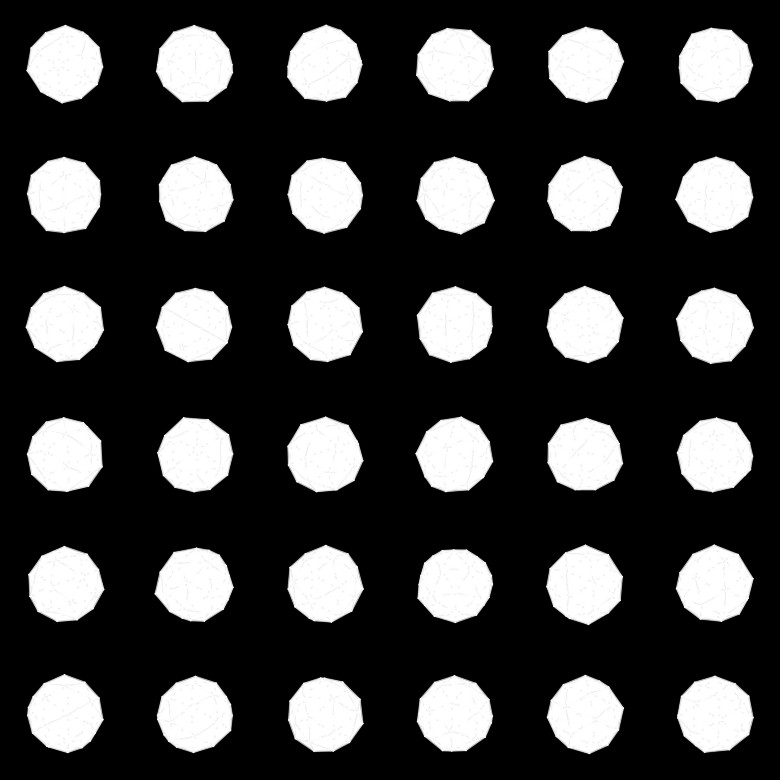


90.59500122070312 113.7668685913086 0.4082227349281311


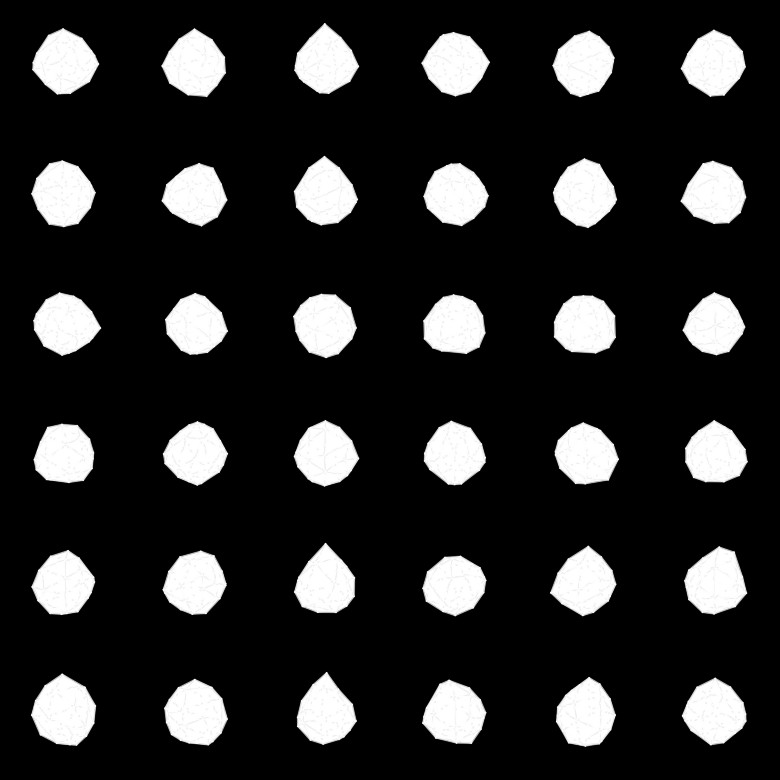


18.819114685058594 21.116600036621094 0.36851924657821655


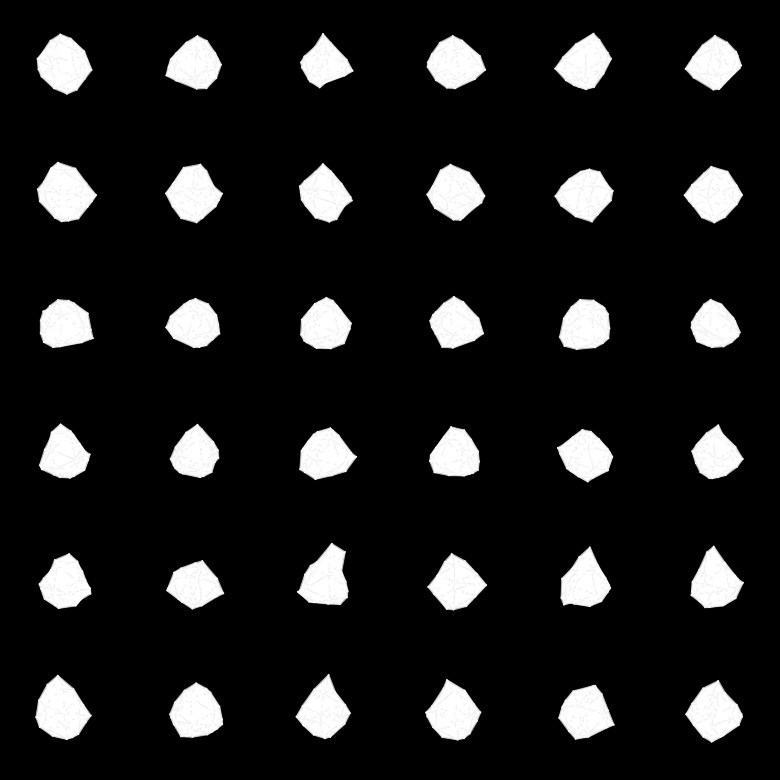


10.09528923034668 13.12936782836914 0.3543461859226227


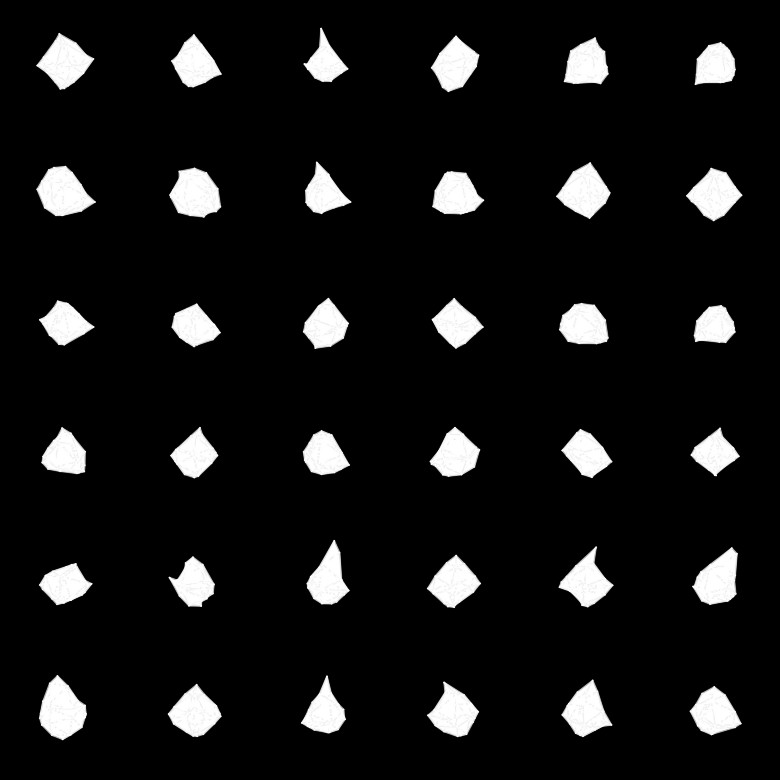


8.030227661132812 9.026702880859375 0.34808897972106934


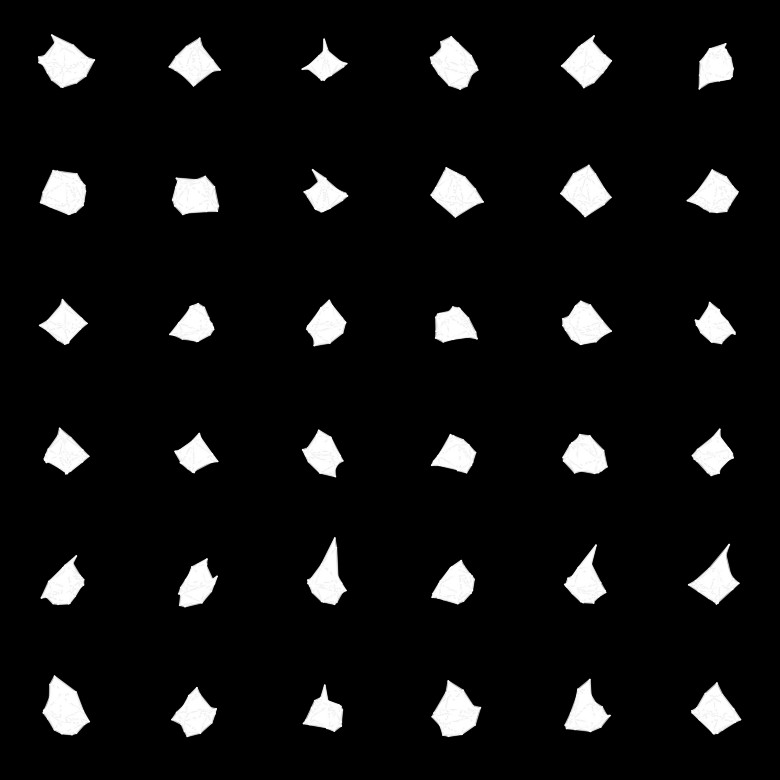


4.332685947418213 4.5654425621032715 0.3351282477378845


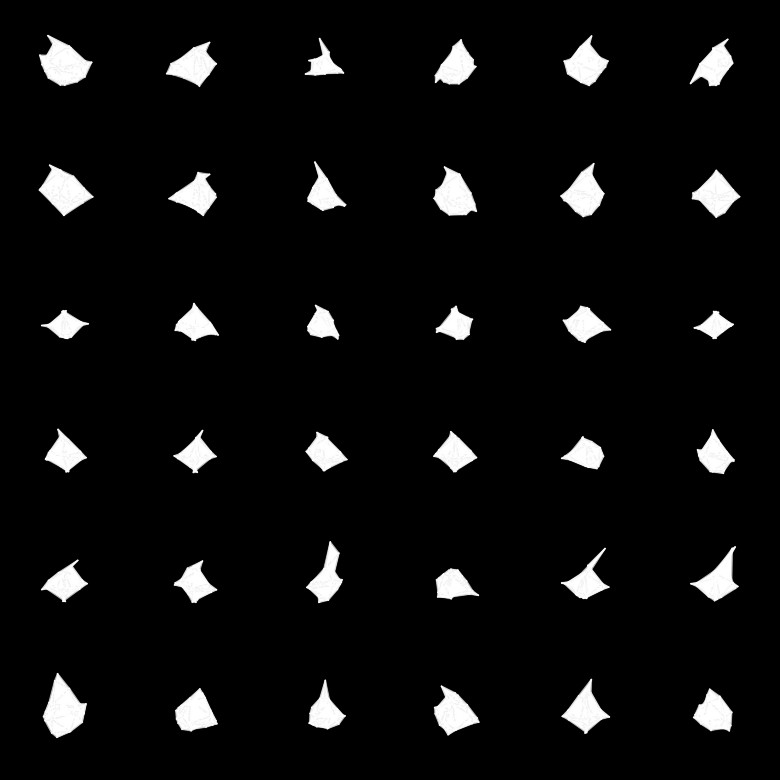


1.7650306224822998 2.0232529640197754 0.32035624980926514


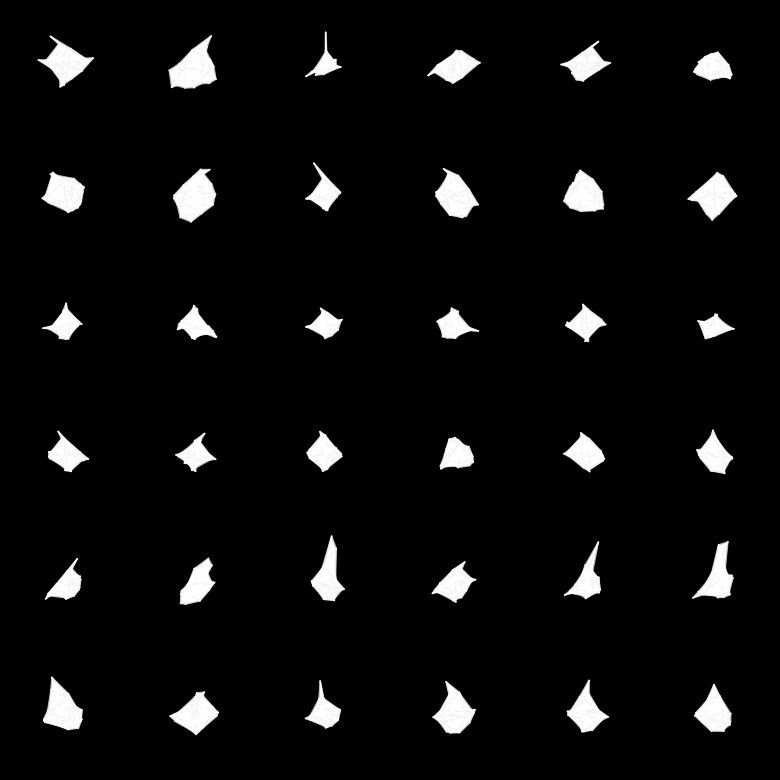


1.641005039215088 1.5173290967941284 0.30441218614578247


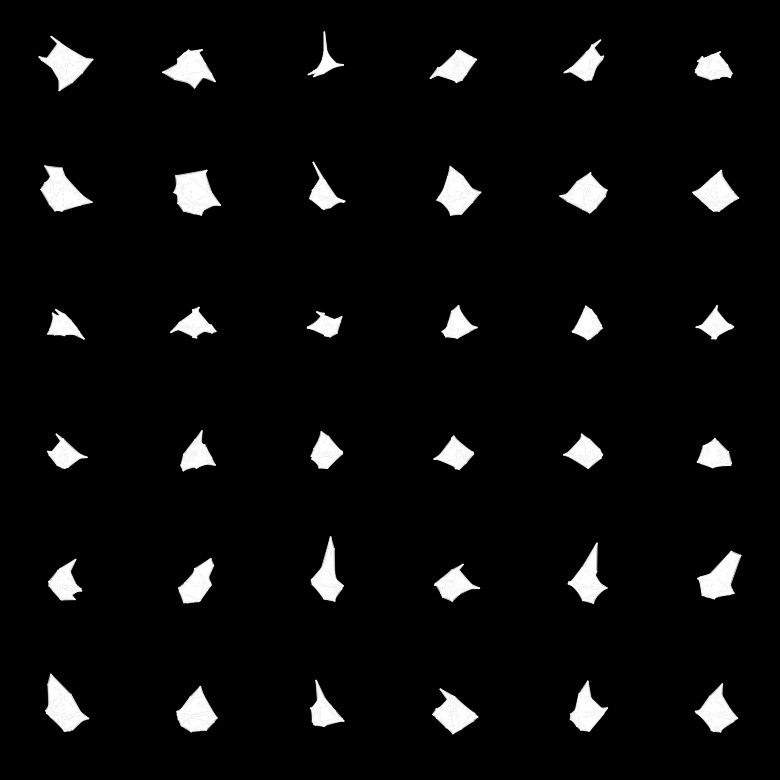


1.1026476621627808 1.1305627822875977 0.29147547483444214


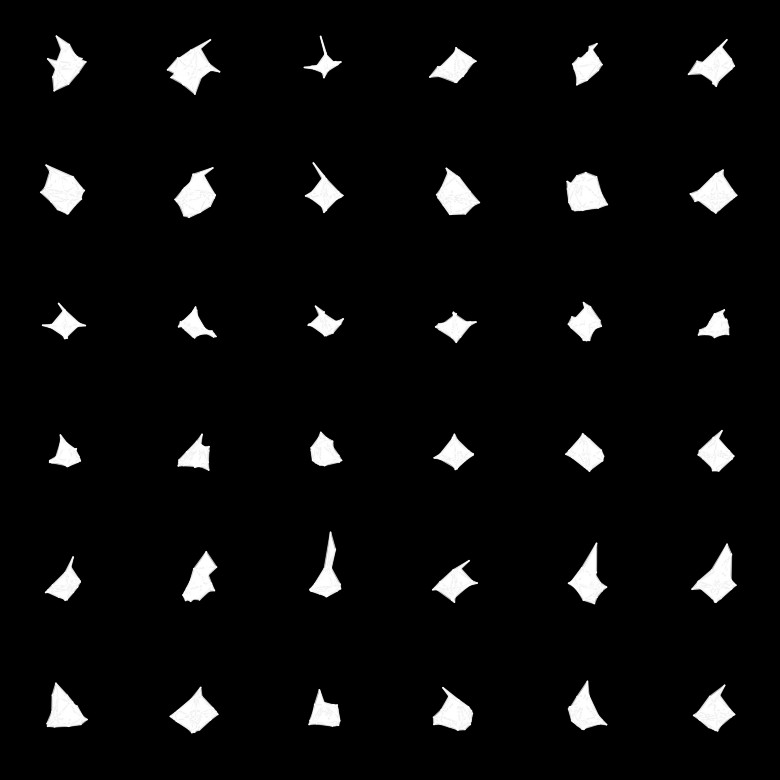


0.8848241567611694 0.91023188829422 0.2786410450935364


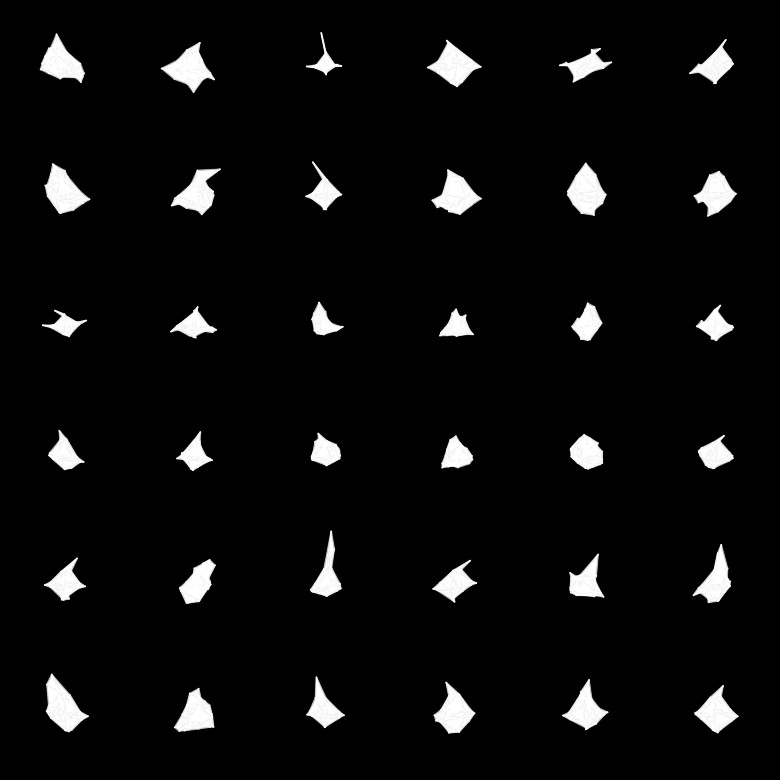


0.7582783699035645 0.7388101816177368 0.26661527156829834


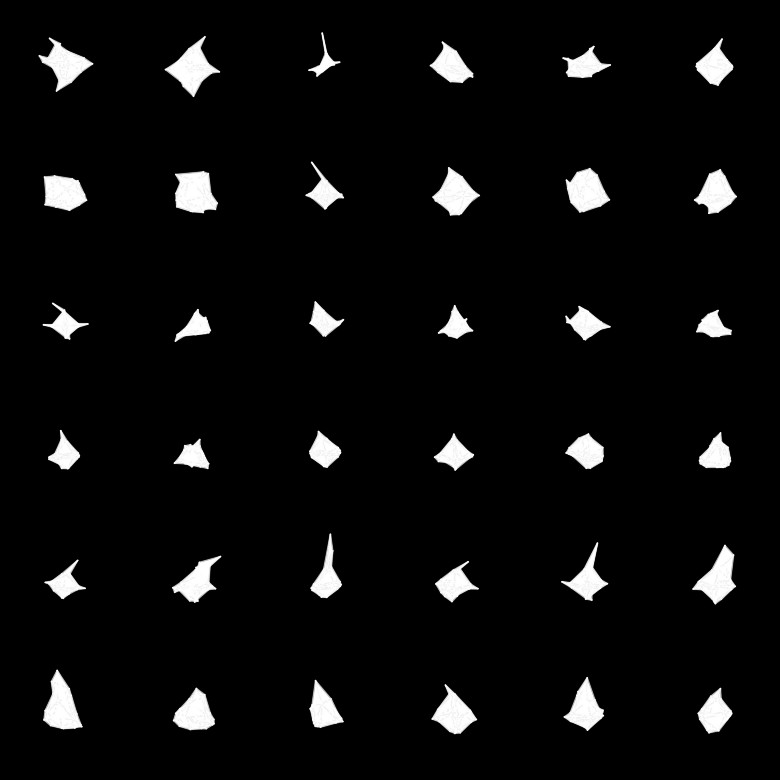


0.6284664869308472 0.6203842163085938 0.25541168451309204


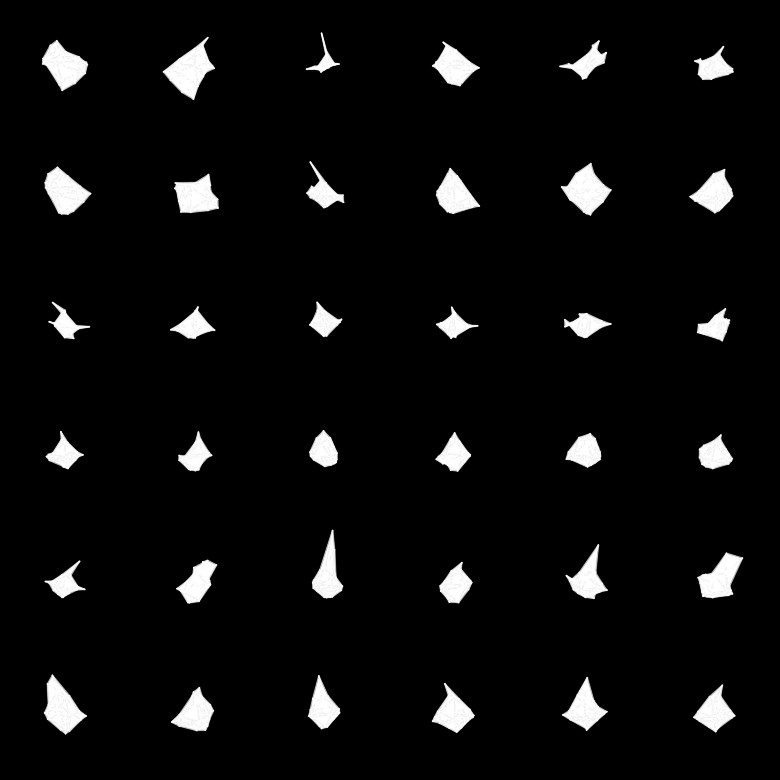


0.42692849040031433 0.552537739276886 0.2452457845211029


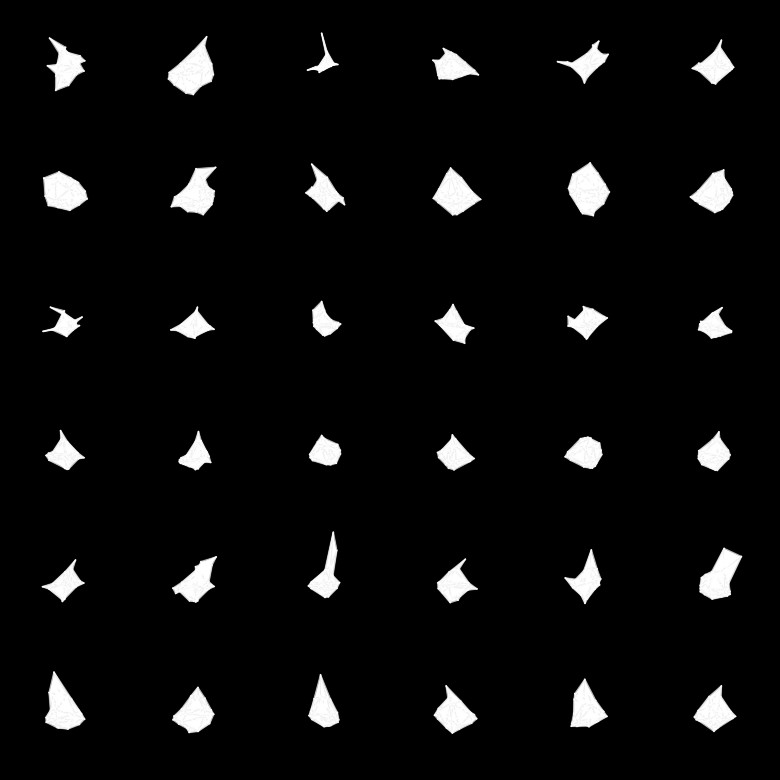


0.4060681164264679 0.4198499023914337 0.23645257949829102


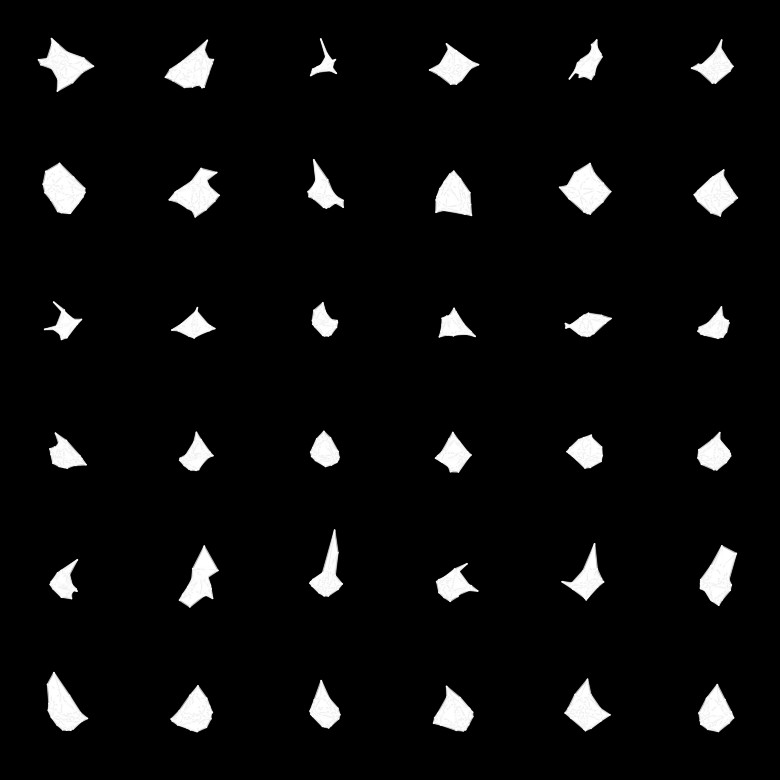


0.2996150255203247 0.3503081500530243 0.22896111011505127


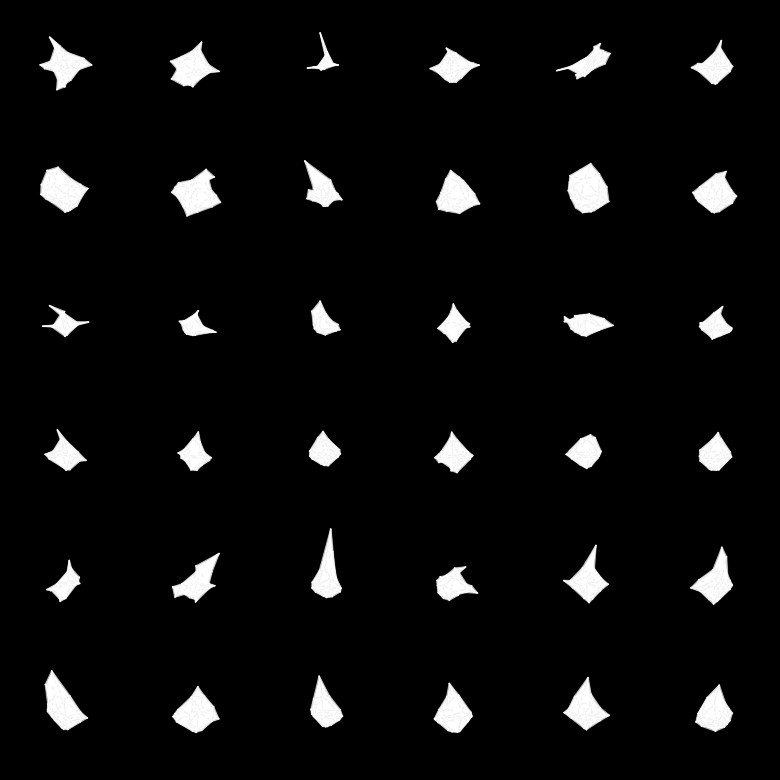


0.22338737547397614 0.2656521201133728 0.2213163524866104


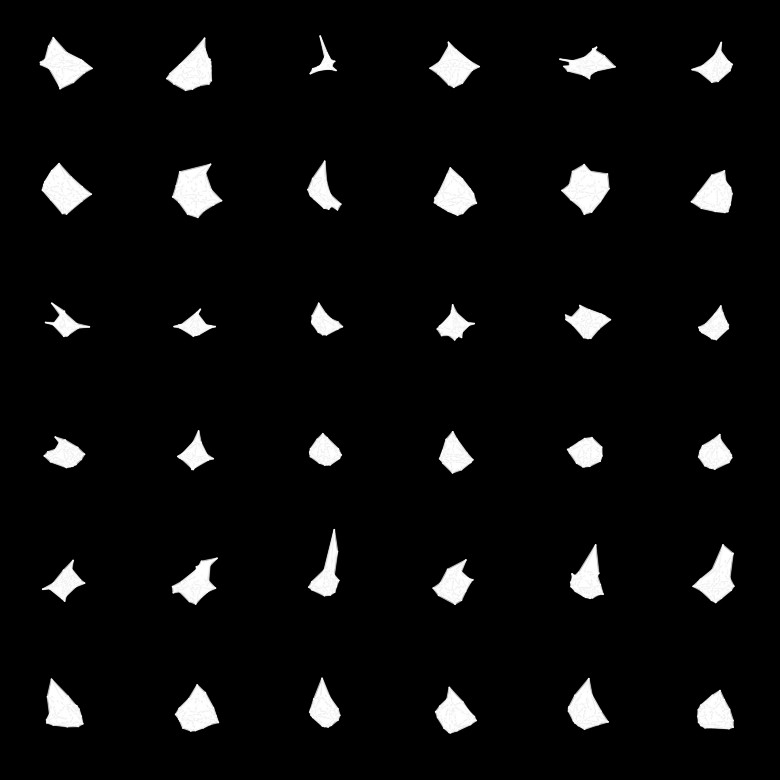


0.16001805663108826 0.2176397442817688 0.21402674913406372


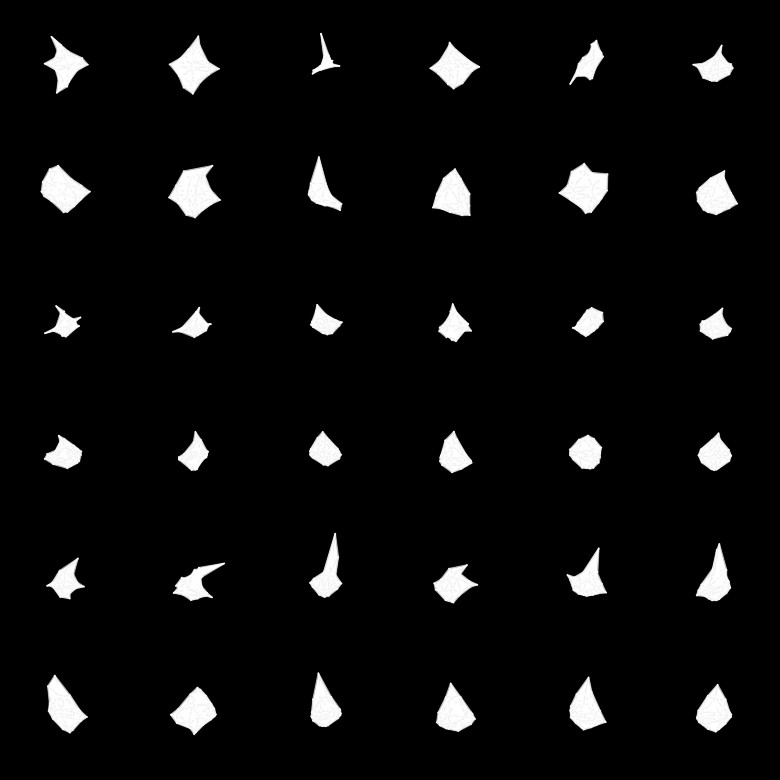


0.07798860967159271 0.13281899690628052 0.2078114151954651


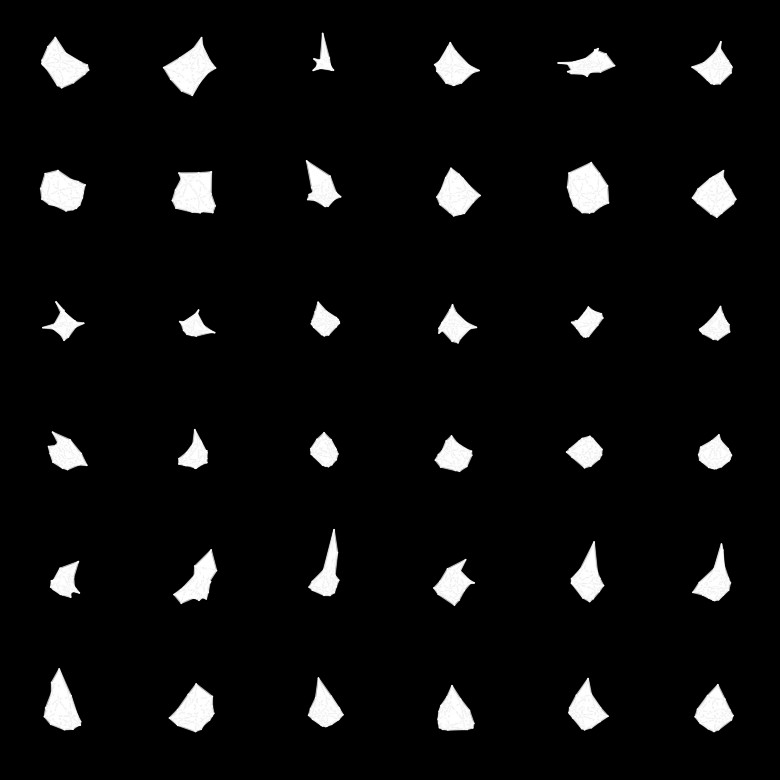


0.055224962532520294 0.055399373173713684 0.20225661993026733


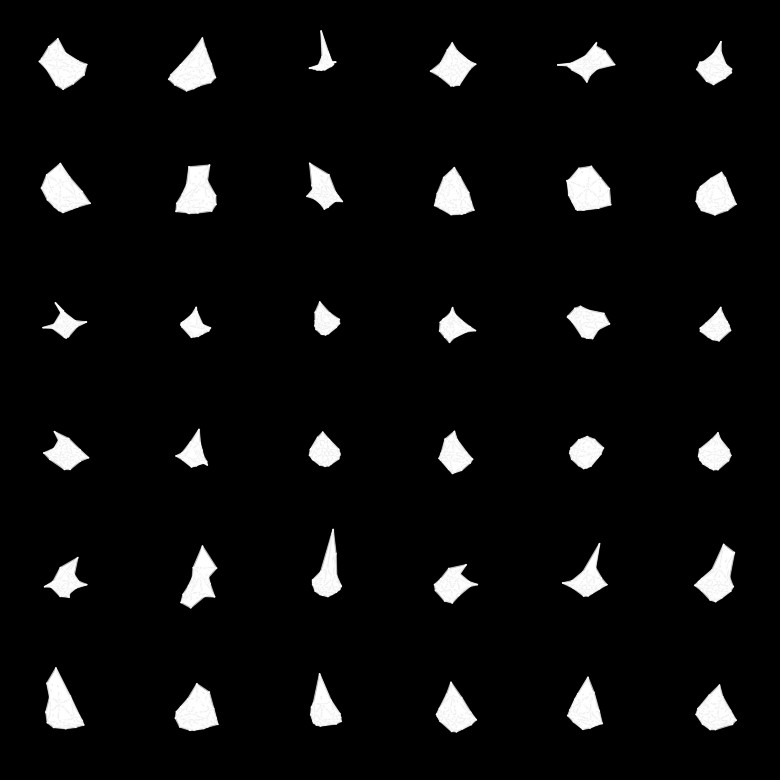


0.033344924449920654 0.03301171213388443 0.19648312032222748


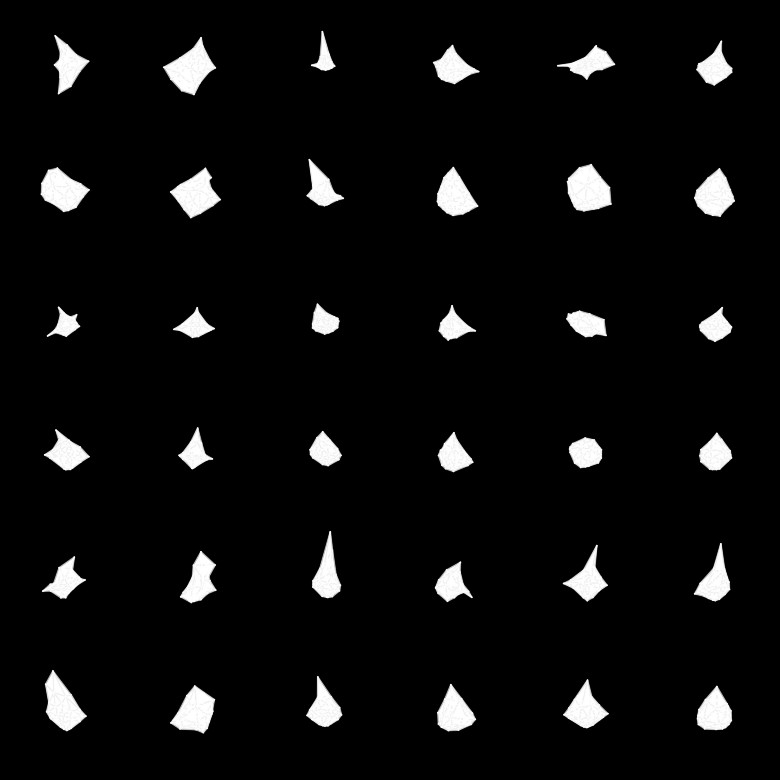


0.05723445862531662 0.03132079914212227 0.19096632301807404


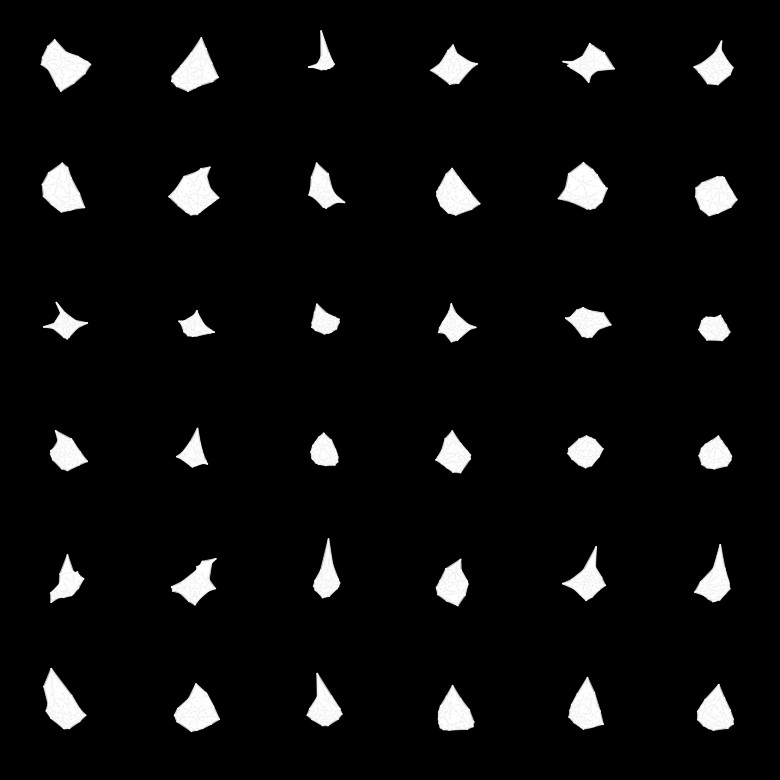


0.017015062272548676 0.01685776188969612 0.18591994047164917


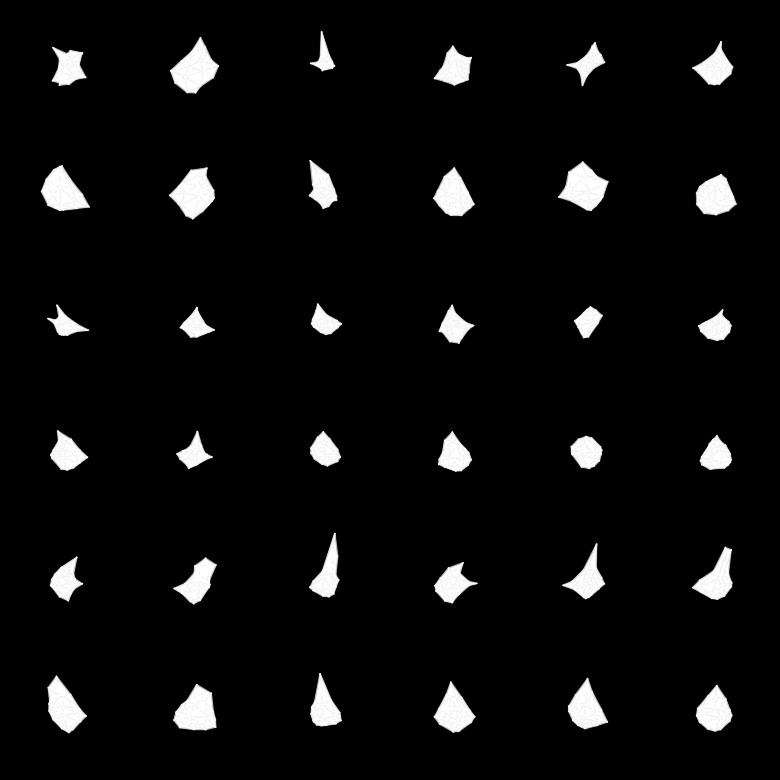


0.026292260736227036 0.02085878886282444 0.18136906623840332


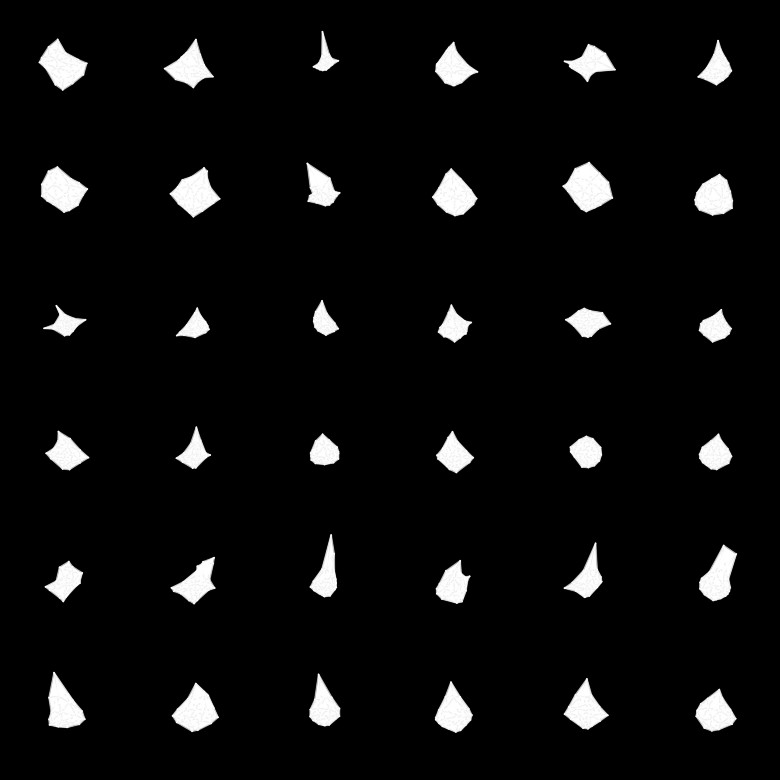


0.017727874219417572 0.013373908586800098 0.1770603060722351


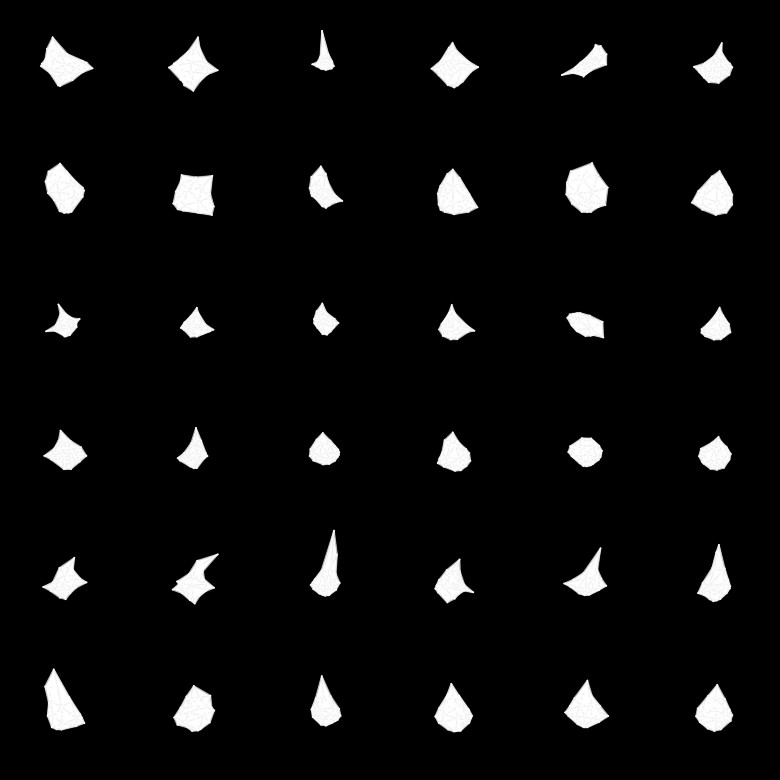


0.019503949210047722 0.026474345475435257 0.17310380935668945


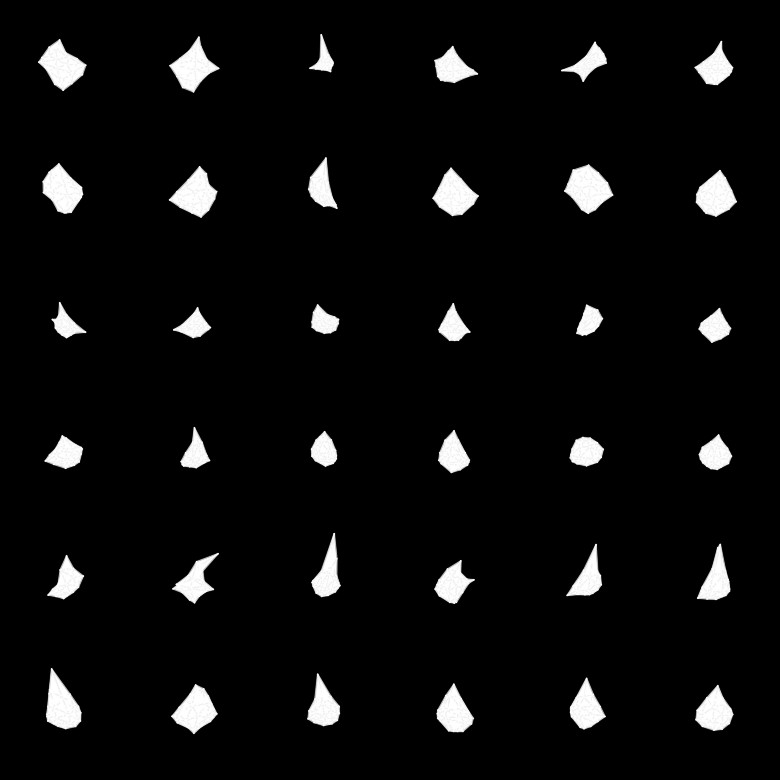


0.017694728448987007 0.02151205949485302 0.16954770684242249


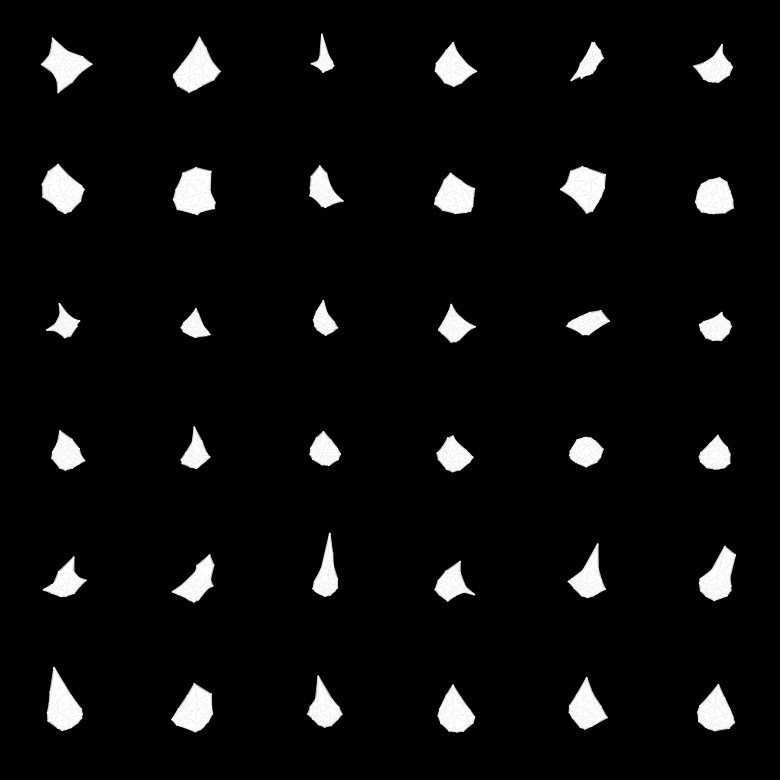


0.007653839886188507 0.01001063920557499 0.16616299748420715


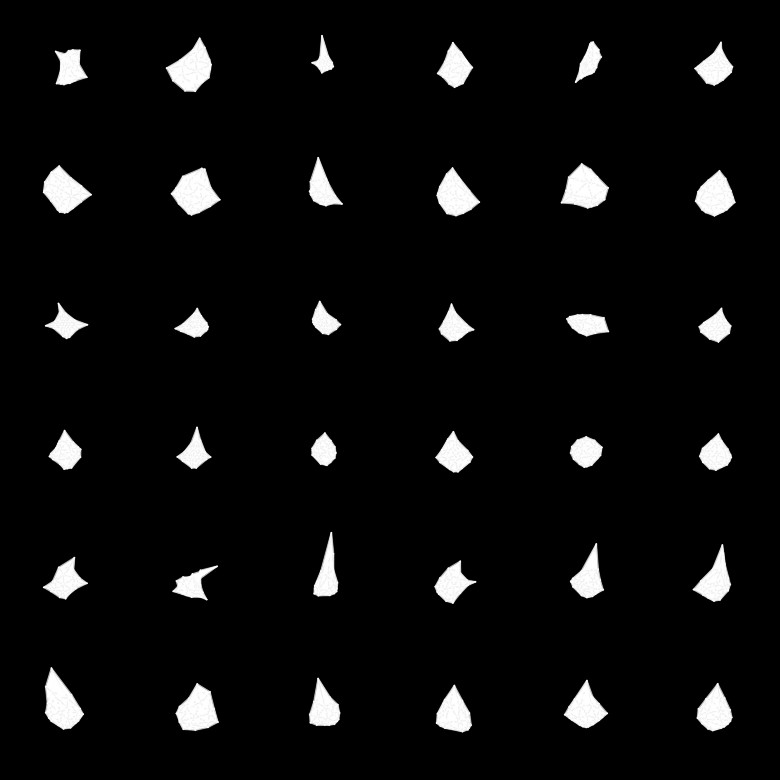


0.00791976135224104 0.011954518966376781 0.16305364668369293


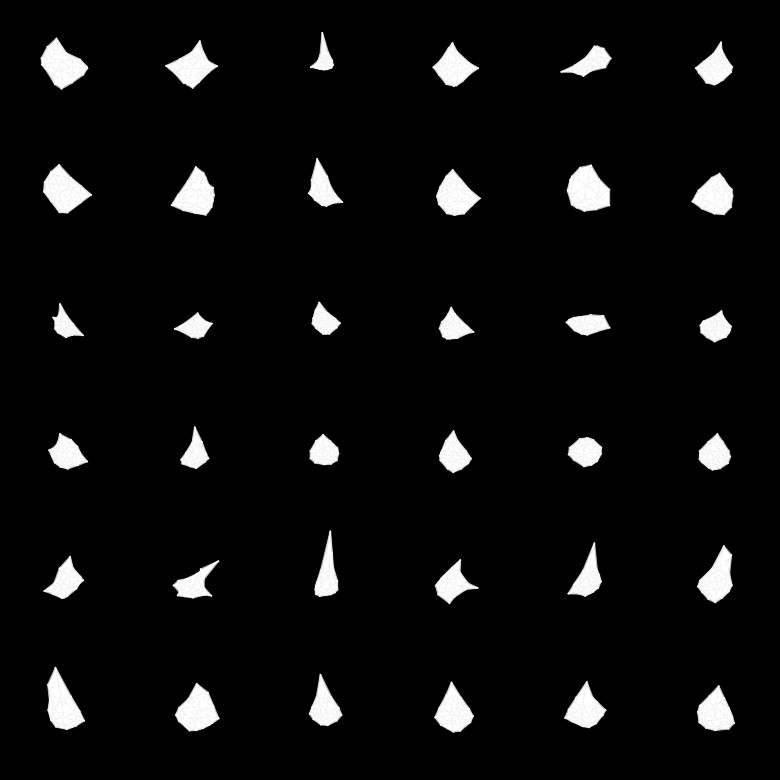


0.011977564543485641 0.009043721482157707 0.16023863852024078


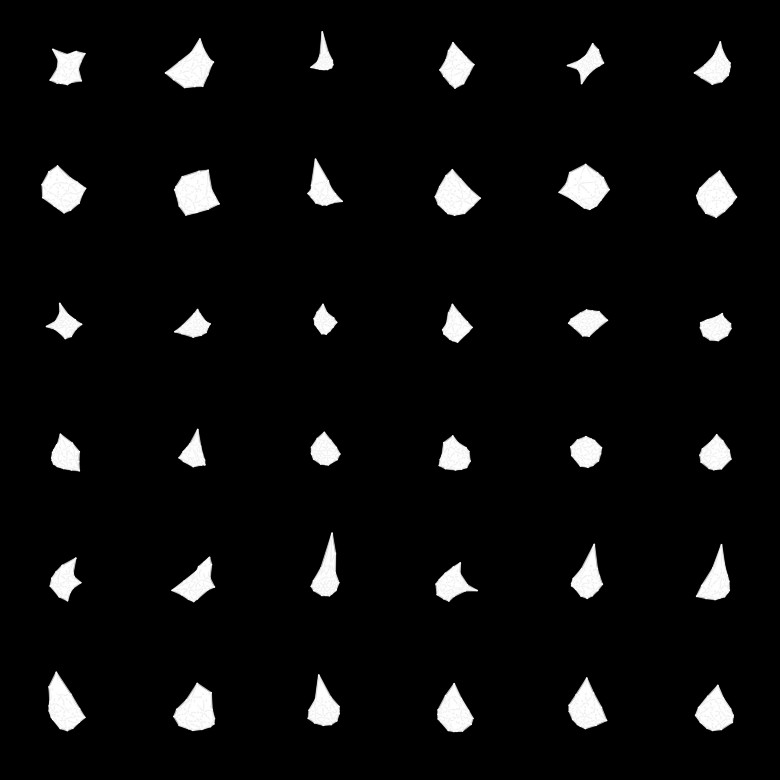


0.006010950542986393 0.010825891979038715 0.1575867235660553


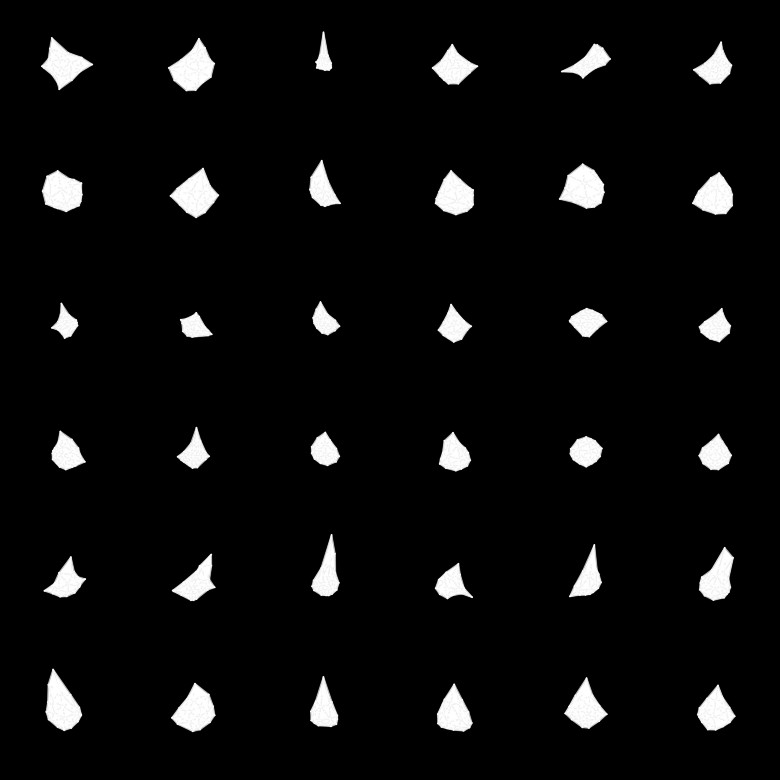


0.012960787862539291 0.012649492360651493 0.15511155128479004


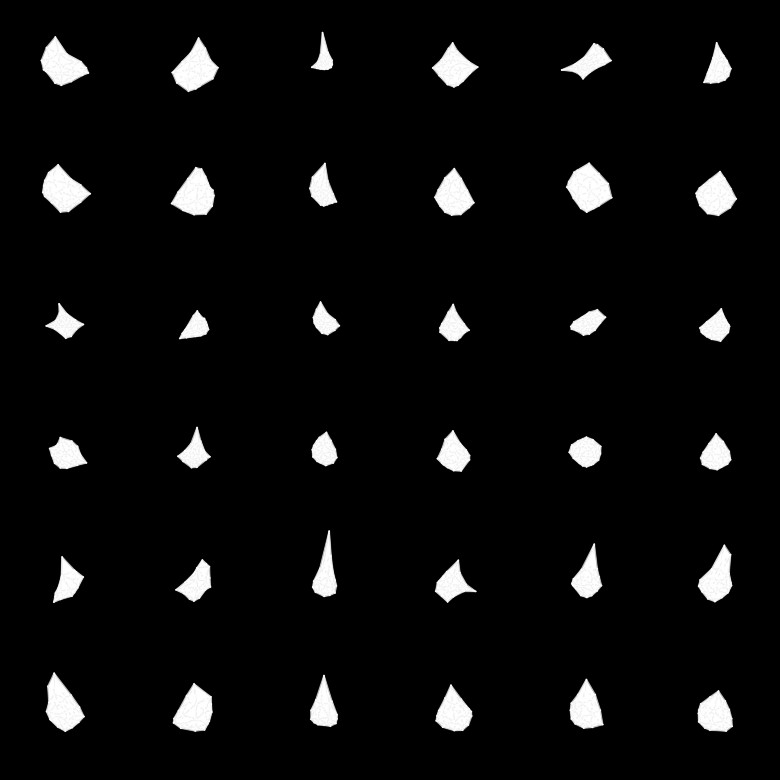


0.006211771629750729 0.009303700178861618 0.15270951390266418


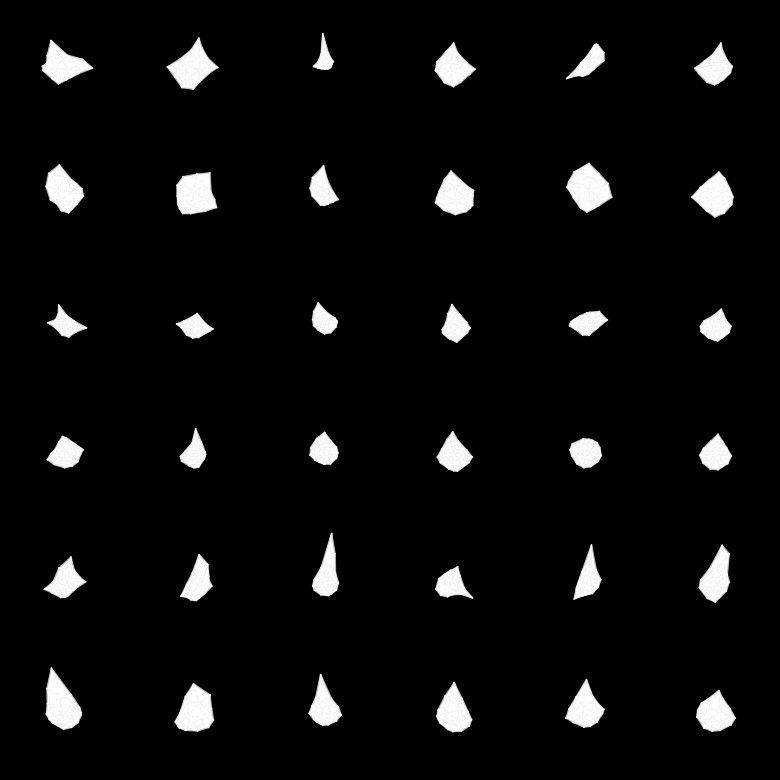


0.0032171972561627626 0.008114754222333431 0.15046970546245575


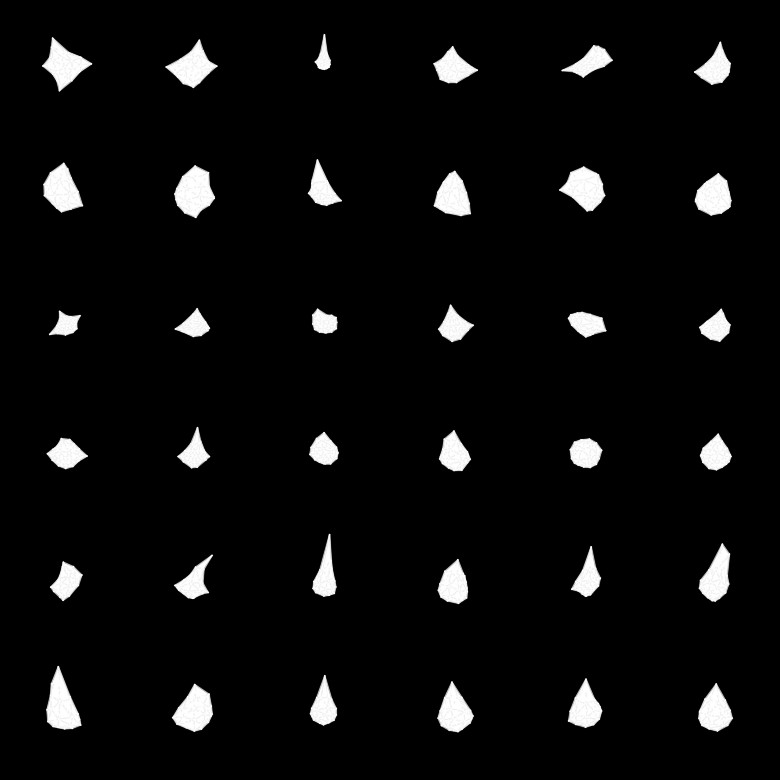


0.005271154455840588 0.005658945068717003 0.14838746190071106


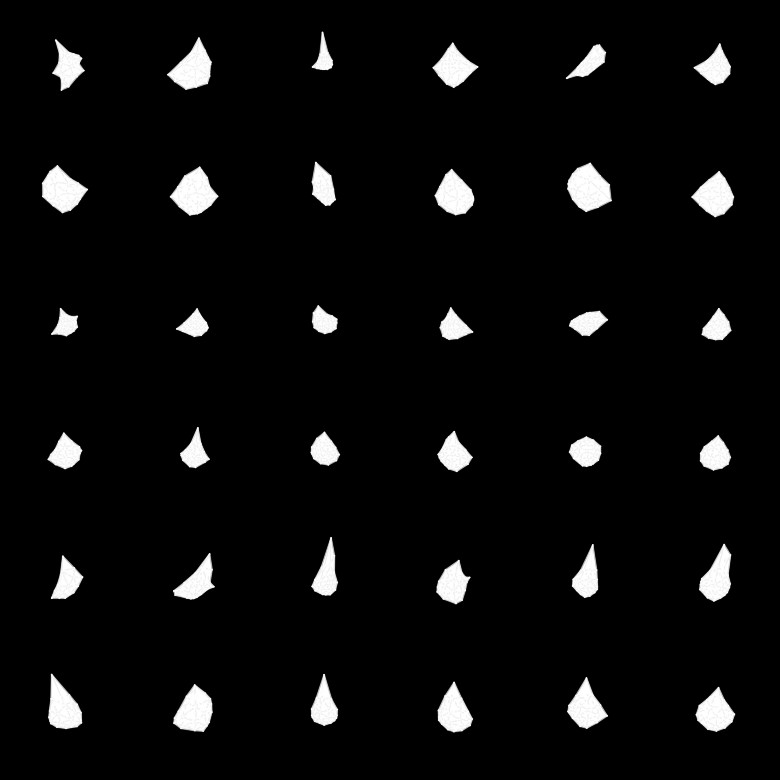


0.004292147234082222 0.0068933372385799885 0.14634352922439575


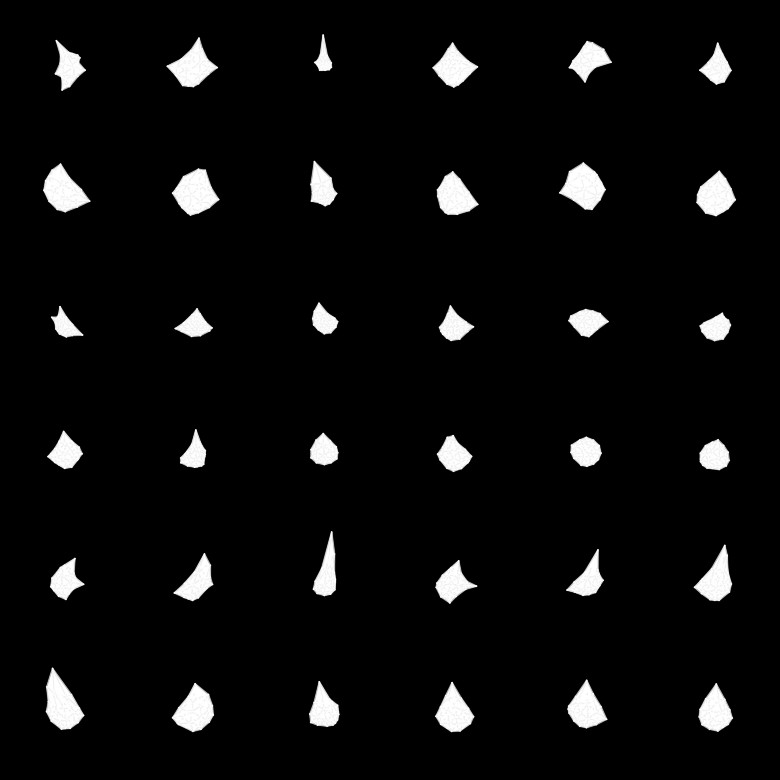


0.009341325610876083 0.00754390237852931 0.14434991776943207


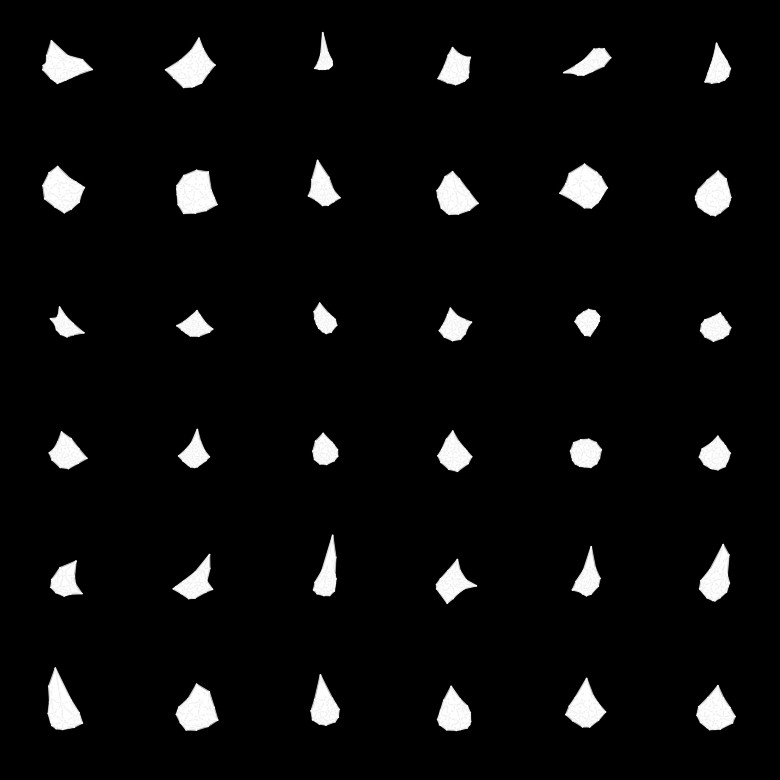


0.005601950921118259 0.004410110879689455 0.14251449704170227


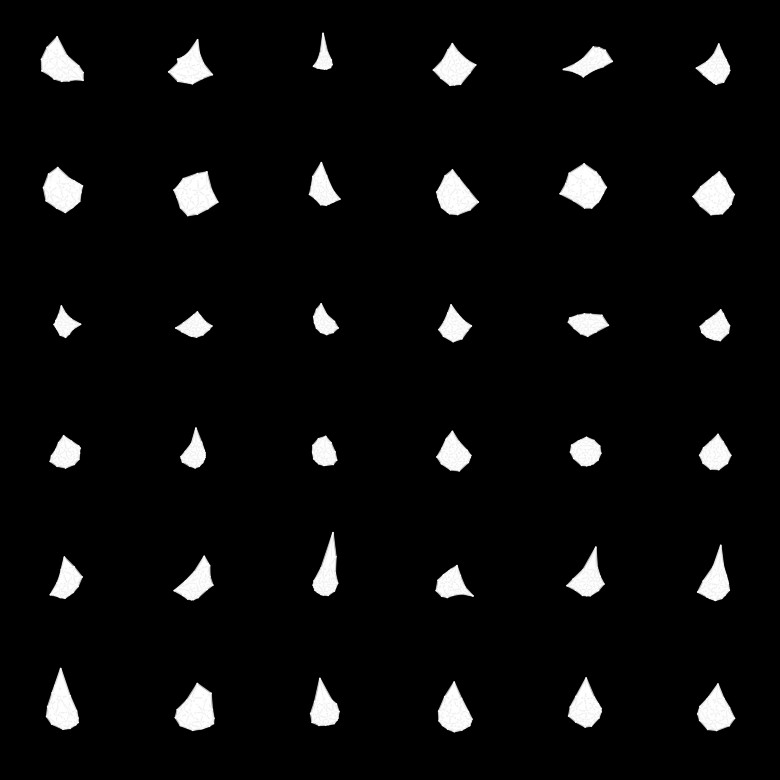


0.005713829305022955 0.004385113716125488 0.14066365361213684


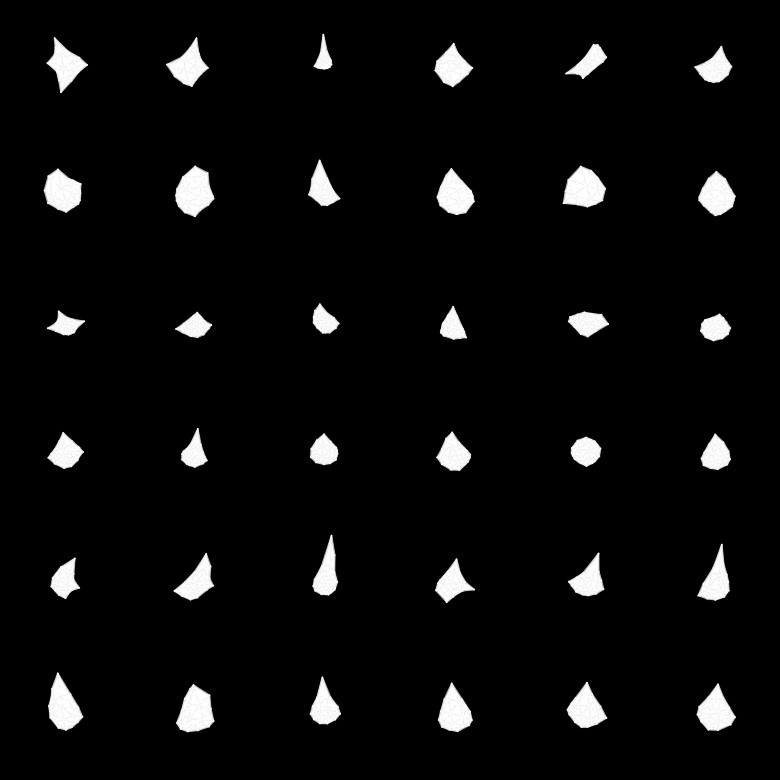

In [16]:
loss_history = []
for i in range(300):
#     opt.zero_grad()
    opt_x.zero_grad()
    opt_c.zero_grad()
    l1_sum = 0
    l2_sum = 0
    ml_sum = 0
    for j in tqdm(range(10)):
        l1, l2, ml = loss(X)
        l1_sum += l1
        l2_sum += l2
        ml_sum += 5 * ml

    l = l1_sum + l2_sum + ml_sum
    loss_history.append((l1_sum.item(), l2_sum.item()))
    l.backward()
#     opt.step()
    opt_x.step()
    opt_c.step()
    if i % 8 == 0:
        print(l1.item(), l2.item(), ml.item())
        draw_tensor( generator(X)[1])

In [17]:
# def generate_images(X):
#     _, imgs
# def group_loss

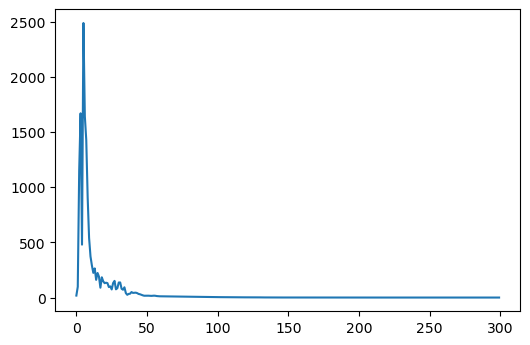

In [18]:
_= plt.plot([lh[0] for lh in loss_history])